# Определение возраста покупателей

# Описание проекта
<br> Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы: 
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении имеется набор фотографий людей с указанием возраста.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский анализ данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

labels.info()

Found 7591 validated image filenames.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропуски отсутствуют, типы данных корректные.

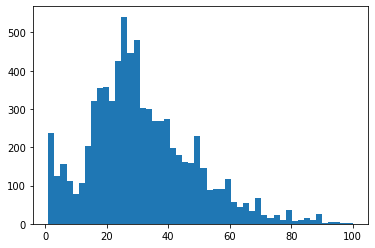

In [2]:
plt.hist(labels['real_age'], bins = 50)
plt.show()

Возраст большинства людей находится в интервале от 20 до 40 лет

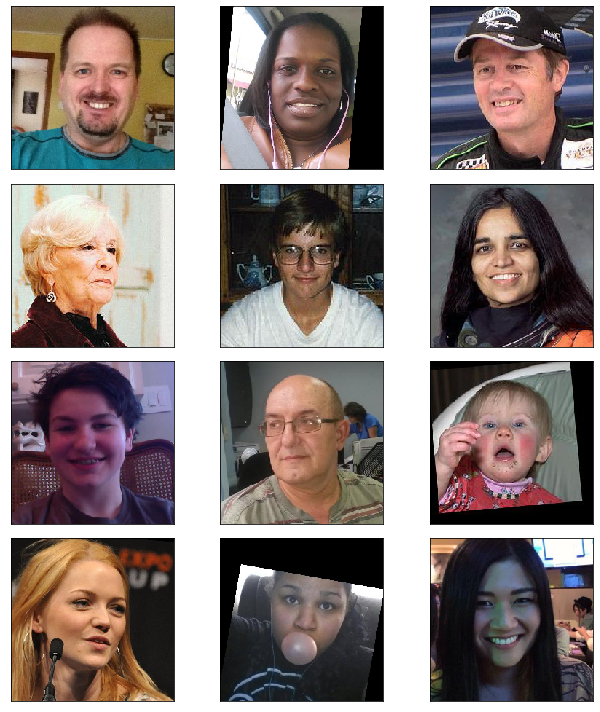

In [3]:
features, target = next(train_gen_flow)

# выводим 12 изображений
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 3, i+1)
    plt.imshow(features[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Основными вызовами интерпретации возраста для модели могут быть качество изображений, мимика и направление, в котором смотрят покупатели. Тестовые данные в целом адекватны реальным с точки зрения распределения возраста, демография на больших датасетах будет похожая.

## Обучение модели

Ниже код обучения модели и её результат вывода на экран:

```python

import pandas as pd
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25
        #horizontal_flip = True,
        #vertical_flip = True,
        #rotation_range = 15
    )
 
    train_datagen_flow = train_datagen.flow_from_dataframe(
        labels,
        directory = path+ '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=0.25)
 
    test_datagen_flow = test_datagen.flow_from_dataframe(
        labels,
        directory = path+'/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Dense(12, activation='relu'))
    model.add(Dense(1,activation='relu'))
    optimizer = Adam(lr = 0.0002)

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, steps_per_epoch=None, validation_steps=None, batch_size=None, epochs=3):

    
    model.fit(train_data,
              validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/3
356/356 - 123s - loss: 232.2334 - mae: 11.0197 - val_loss: 316.7508 - val_mae: 13.1937
Epoch 2/3
356/356 - 37s - loss: 87.6701 - mae: 7.1994 - val_loss: 152.1574 - val_mae: 9.5706
Epoch 3/3
356/356 - 37s - loss: 50.0397 - mae: 5.4627 - val_loss: 88.6083 - val_mae: 7.0405
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 88.6083 - mae: 7.0405
Test MAE: 7.0405



```

## Анализ обученной модели

При обучении применялась модель с архитектурой ResNet50 с одним полносвязным нейроном в последнем слое. Результаты удовлетворительные - средняя ошибка по прошествии 3 эпох обучения составила 7 лет, что в целом является приемлемым показателем для задачи формирования специализированных предложений в зависимости от возрастной группы покупателя. Для задачи проверки добросовестности кассира при продаже алкоголя требуется точная модель, ибо смазанных границ там нет.